In [1]:
## SECTION 0. Library imports.
import mysql.connector
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from scipy import stats
from IPython.display import HTML
%matplotlib inline

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
## SECTION 1. Phone grade distribution and evolution.
## Step 1. Read the server credentials from the settings file.
file_path = os.path.join(os.getcwd(), 'Settings')
with open(os.path.join(file_path,'settingsSQL.txt'), 'r') as settings_file:
    content = settings_file.readlines()
content = [item.strip().split(' = ')[1] for item in content]
## Step 2. Connection to the database.
conn = mysql.connector.connect(host = content[0],
                               user = content[1],
                               password = content[2],
                               db= content[3])
cursor = conn.cursor()
## Step 3. Query the database for the visual inspection grades for phones.
cursor.execute(r"SELECT * FROM product \
                INNER JOIN product_type ON product.product_type_idproduct_type = product_type.idproduct_type\
                INNER JOIN process_history ON product.idproduct = process_history.product_idproduct \
                INNER JOIN visual_inspection ON process_history.idprocess = visual_inspection.process_history_idprocess \
                WHERE product_type.type = 'mobile phone';")
rows = cursor.fetchall()
connection_closed = cursor.close()

In [4]:
## Step 4. Construct a dataframe with the results.
column_names = ['idproduct', 'br_number_idbr_number', 'manufacturer_idmanufacturer', 'product_type_idproduct_type', 
               'box_idbox', 'model_idmodel', 'serialnumber', 'decomm_id', 'customer_ref', 'asset_tag', 'processType', 
               'estimated_price', 'sold_to', 'warranty', 'finished_processing', 'value', 'pallet_id', 'idproduct_type', 
               'type', 'idprocess', 'start_time', 'end_time', 'station_idstation', 'product_idproduct', 
               'process_types_idprocess_types', 'pass_fail', 'estimated_process_cost', 'box_id', 'idvisual_inspection', 
               'process_history_idprocess', 'grade', 'comments']
raw_data_frame = pd.DataFrame(list(rows), columns = column_names)
## Step 5. Remove unnecesary columns.
raw_data_frame.drop(labels=['product_type_idproduct_type', 'box_idbox', 'serialnumber', 'decomm_id',
                         'customer_ref', 'asset_tag', 'estimated_price', 'pallet_id', 'idproduct_type',
                         'idvisual_inspection', 'process_history_idprocess',
                         'estimated_process_cost'],
                 axis = 1, inplace = True)
## Step 6. Rename remaining columns.
raw_data_frame.rename(columns={'idproduct':'id_product','br_number_idbr_number':'batch_number', 'manufacturer_idmanufacturer':'manufacturer_id',
                            'model_idmodel':'model_id', 'processType':'process_type_path', 'sold_to':'sold_to',
                            'warranty':'warranty', 'finished_processing':'finish_processing','value':'value',
                            'type':'product_type','idprocess':'process_id', 'start_time':'start_time', 'end_time':'end_time',
                            'station_idstation':'station_id', 'process_types_idprocess_types':'process_type',
                            'pass_fail':'pass_fail','box_id':'box_id', 'grade':'grade', 'comments':'comments',
                             'product_idproduct':'product_id'},
                   inplace = True)

In [5]:
## Step 7. Change the start time to time format and set as the index for the dataframe.
raw_data_frame['start_time'] = pd.to_datetime(raw_data_frame['start_time'])
raw_data_frame.set_index(raw_data_frame['start_time'], drop=True, inplace=True)

In [6]:
## Step 8. Distribution of grades per product type.
def grade_distribution(grade_column):
    """
    This function gets the grade distribution for each grade type.

    Parameters
    ----------
    grade_column : List
        The grade for each product for which the distribution is calculated.

    Returns
    -------
    result_data_frame : Dataframe
        Dataframe with the distribution of grades as a count and also as a percentage.
    """
    ## Step 1. Define the possible grade values.
    grades = ['C', 'B', 'A', 'Z', 'D', 'A*', 'E']
    ## Step 2. For each value get the number of times the grade is seen in numbers and in percentage.
    count_grades = []
    percentage_grades = []
    for grade in grades:
        temp = len(grade_column[grade_column == grade])
        count_grades.append(temp)
    total_products = sum(count_grades)
    percentage_grades = [round(grade_count / total_products, 2) if total_products > 0 else 0 for grade_count in count_grades]
    ## Step 3. Return as a dataframe.
    return [grades, count_grades, percentage_grades]

In [7]:
## Step 9. Grade distribution per year.
grades_year = raw_data_frame['grade'].resample('BA').apply(grade_distribution) ## Business end year.
grades_quarter = raw_data_frame['grade'].resample('BQ').apply(grade_distribution) ## Business quarter end.
grades_month = raw_data_frame['grade'].resample('BM').apply(grade_distribution) ## Business month end.
grades_day = raw_data_frame['grade'].resample('B').apply(grade_distribution) ## Business day.
# grades_hour = raw_data_frame['grade'].resample('H', closed='right').apply(grade_distribution) ##  Hour.

In [8]:
type(grades_month)

pandas.core.series.Series

In [9]:
## Step 10. Scrapped products.
## Step 10.1. Retrieve information from database for products with process type equal to strip and scrap (8) or sold for destruction.
cursor = conn.cursor()
## Step 10.2. Query to the database.
cursor.execute(r"SELECT DISTINCT(idproduct) FROM product \
                 INNER JOIN process_history ON product.idproduct = process_history.product_idproduct \
                 WHERE product.sold_to LIKE '%destruction%' OR process_types_idprocess_types = 8;")
rows = cursor.fetchall()
connectionClosed = cursor.close()
## Step 10.3. Name columns.
column_names = ['product_id']
temp_data_frame = pd.DataFrame(list(rows), columns = column_names)
## Step 10.4. Merge dataframes by product_id.
temp_data_frame = pd.merge(raw_data_frame, temp_data_frame, on='product_id')

In [10]:
## Step 10.5. Change the start time to time format and set as the index for the dataframe.
temp_data_frame['start_time'] = pd.to_datetime(temp_data_frame['start_time'])
temp_data_frame.set_index(temp_data_frame['start_time'], drop=True, inplace=True)

In [11]:
## Step 10.6. Resample to get the number of products per quarter.
grades_quarter_scrapped = temp_data_frame['grade'].resample('BQ').count() ## Business quarter end.
grades_quarter_total = raw_data_frame['grade'].resample('BQ').count()

In [12]:
## Step 10.7. Overall grading reliability.
overall_grading_unreliability = grades_quarter_scrapped / grades_quarter_total

In [13]:
## Step 11. Graph the products per month on actual units.
plot_data_frame = pd.DataFrame(data = [x[1] for x in grades_month],
                               columns=grades_month[0][0],
                               index=grades_month.index)

In [14]:
plot_data_frame

,C,B,A,Z,D,A*,E
start_time,,,,,,,
2015-11-30,554,126,13,387,150,0,0
2015-12-31,395,290,6,124,85,0,0
2016-01-29,636,252,63,395,193,3,0
2016-02-29,452,347,30,548,208,2,0
2016-03-31,888,194,19,561,191,1,0
2016-04-29,914,444,52,1016,144,4,0
2016-05-31,548,110,19,881,174,3,0
2016-06-30,502,161,72,891,128,2,0
2016-07-29,288,73,6,359,331,0,0


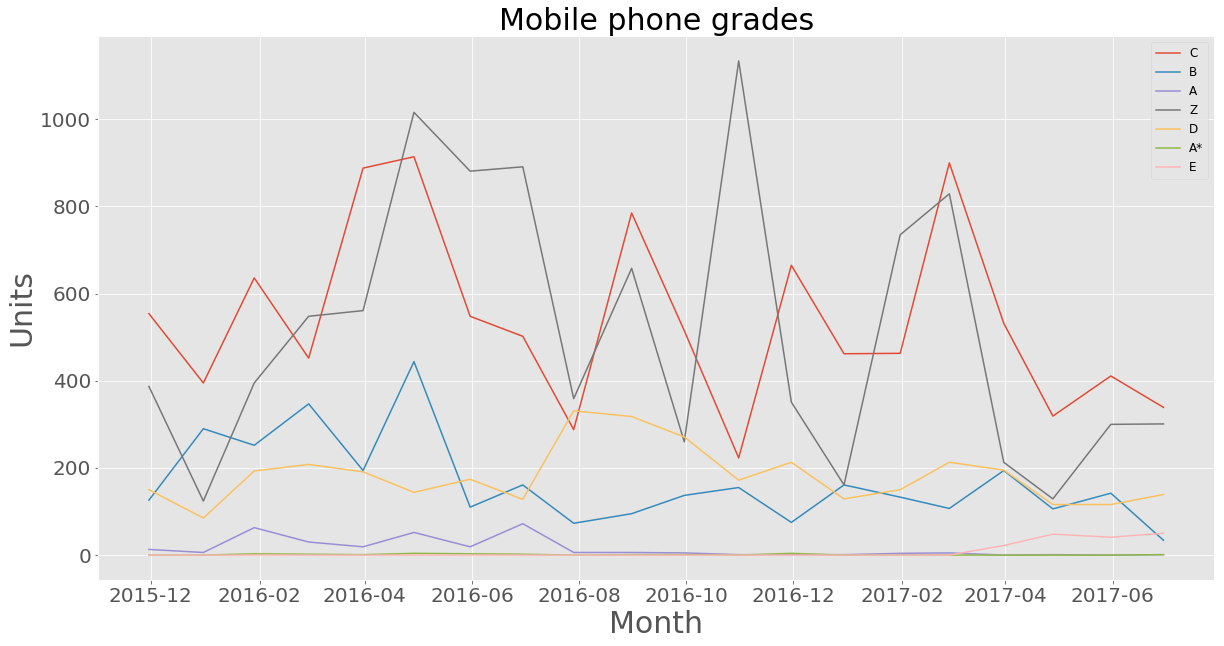

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
plt.xticks(size=20)
plt.yticks(size=20)
plt.plot(plot_data_frame)
plt.legend(plot_data_frame.columns, loc=0, fontsize='large')
plt.xlabel('Month', fontsize=30)
plt.ylabel('Units', fontsize=30)
plt.title('Mobile phone grades', fontsize=30)

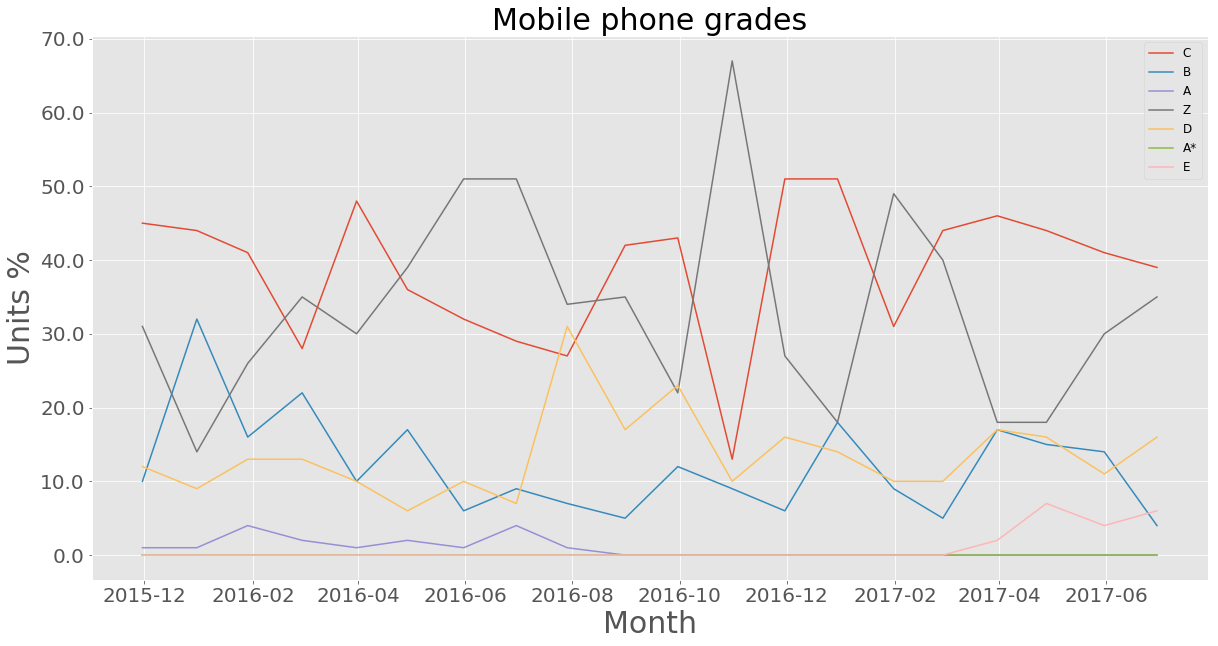

In [16]:
## Step 11.1 Graph the products per month on percentages.
def percentage_formatter(x, pos):
    return '%1.1f'%(100 * x)
plot_data_frame = pd.DataFrame(data = [x[2] for x in grades_month],
                               columns=grades_month[0][0],
                               index=grades_month.index)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
plt.xticks(size=20)
plt.yticks(size=20)
plt.plot(plot_data_frame)
plt.legend(plot_data_frame.columns, loc=0, fontsize='large')
plt.xlabel('Month', fontsize=30)
plt.ylabel('Units %', fontsize=30)
plt.title('Mobile phone grades', fontsize=30)

In [17]:
## Step 12. Quarter based histogram for grades.
grades_quarter_2015 = grades_quarter['2015']
grades_quarter_2016 = grades_quarter['2016']
grades_quarter_2017 = grades_quarter['2017']

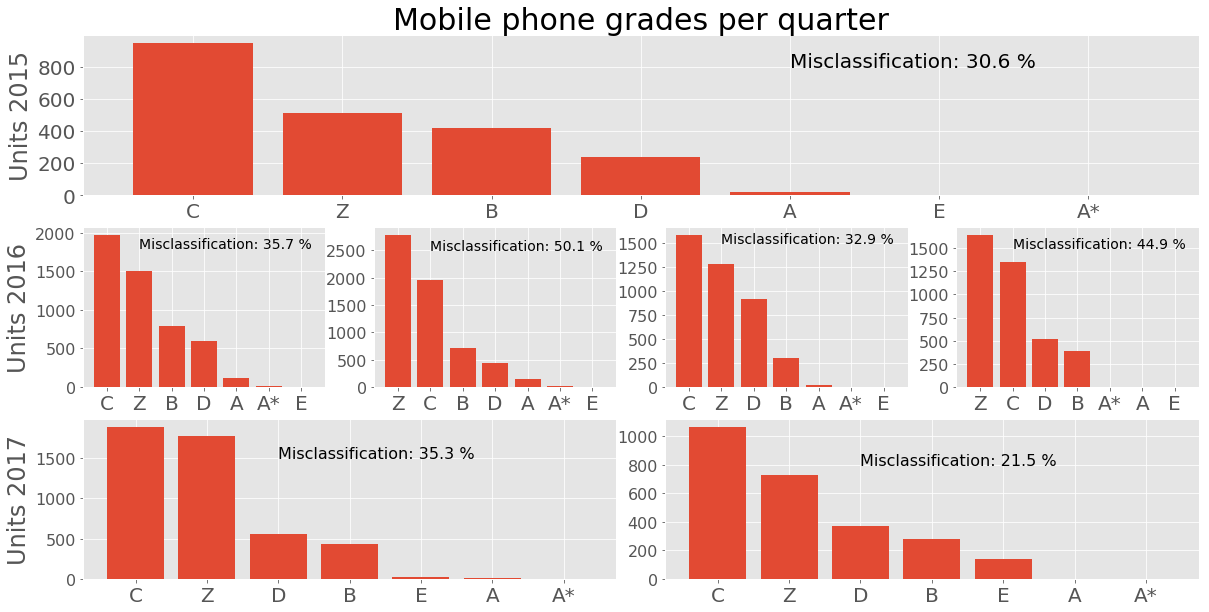

In [18]:
## Step 13. Quarter based histograms.
plot_data_frame = pd.DataFrame(data = [x[1] for x in grades_quarter_2015],
                               columns=grades_quarter_2015[0][0],
                               index=grades_quarter_2015.index)
# Step 13.1.Set up the subplot grid.
gridspec.GridSpec(nrows=3,ncols=4)
## Step 13.2. 2015 information.
plt.subplot2grid(shape=(3, 4), loc=(0, 0), colspan=4, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[0].sort_values(axis=0, ascending=False))
plt.title('Mobile phone grades', fontsize=30)
# plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
plt.yticks(size=20)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.title('Mobile phone grades per quarter', fontsize=30)
plt.ylabel('Units 2015', fontsize=24)
plt.text(4, 800, r'Misclassification: %s %%' % round((overall_grading_unreliability[0] * 100), 1), fontsize = 20)
## Step 13.3. 2016 information.
plot_data_frame = pd.DataFrame(data = [x[1] for x in grades_quarter_2016],
                               columns=grades_quarter_2016[0][0],
                               index=grades_quarter_2016.index)
## Step 13.3.1. Q1.
plt.subplot2grid(shape=(3, 4), loc=(1, 0), colspan=1, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[0].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.ylabel('Units 2016', fontsize=24)
plt.text(1, 1800, r'Misclassification: %s %%' % round((overall_grading_unreliability[1] * 100), 1), fontsize = 14)
## Step 13.3.2. Q2.
plt.subplot2grid(shape=(3, 4), loc=(1, 1), colspan=1, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[1].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[1].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[1].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.text(1, 2500, r'Misclassification: %s %%' % round((overall_grading_unreliability[2] * 100), 1), fontsize = 14)
## Step 13.3.3. Q3.
plt.subplot2grid(shape=(3, 4), loc=(1, 2), colspan=1, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[2].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[2].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[2].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.text(1, 1500, r'Misclassification: %s %%' % round((overall_grading_unreliability[3] * 100), 1), fontsize = 14)
## Step 13.3.4. Q4.
plt.subplot2grid(shape=(3, 4), loc=(1, 3), colspan=1, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[3].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[3].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[3].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.text(1, 1500, r'Misclassification: %s %%' % round((overall_grading_unreliability[4] * 100), 1), fontsize = 14)
## Step 13.3. 2017 information.
plot_data_frame = pd.DataFrame(data = [x[1] for x in grades_quarter_2017],
                               columns=grades_quarter_2017[0][0],
                               index=grades_quarter_2017.index)
## Step 13.3.1. Q1.
plt.subplot2grid(shape=(3, 4), loc=(2, 0), colspan=2, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[0].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[0].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.ylabel('Units 2017', fontsize=24)
plt.text(2, 1500, r'Misclassification: %s %%' % round((overall_grading_unreliability[5] * 100), 1), fontsize = 16)
## Step 13.3.2. Q2.
plt.subplot2grid(shape=(3, 4), loc=(2, 2), colspan=2, rowspan=1)
plt.bar(left=np.arange(len(plot_data_frame.iloc[1].sort_values(axis=0, ascending=False).index)), height=plot_data_frame.iloc[1].sort_values(axis=0, ascending=False))
plt.yticks(size=16)
plt.xticks(size=20)
x_ticks = (plot_data_frame.iloc[1].sort_values(axis=0, ascending=False).index).values
plt.xticks(range(7), x_ticks)
plt.text(2, 800, r'Misclassification: %s %%' % round((overall_grading_unreliability[6] * 100), 1), fontsize = 16)

In [19]:
## SECTION 2. Processing times distribution.
## Step 1. Query the database for the process information for phones.
cursor = conn.cursor()
cursor.execute(r"SELECT * FROM product \
                 INNER JOIN product_type ON product.product_type_idproduct_type = product_type.idproduct_type \
                 INNER JOIN process_history ON product.idproduct = process_history.product_idproduct \
                 WHERE product_type.type  = 'mobile phone';")
rows = cursor.fetchall()
connection_closed = cursor.close()

In [20]:
## Step 2. Construct a dataframe with the results.
column_names = ['idproduct', 'br_number_idbr_number', 'manufacturer_idmanufacturer', 'product_type_idproduct_type', 
               'box_idbox', 'model_idmodel', 'serialnumber', 'decomm_id', 'customer_ref', 'asset_tag', 'processType', 
               'estimated_price', 'sold_to', 'warranty', 'finished_processing', 'value', 'pallet_id', 'idproduct_type', 
               'type', 'idprocess', 'start_time', 'end_time', 'station_idstation', 'product_idproduct', 
               'process_types_idprocess_types', 'pass_fail', 'estimated_process_cost', 'box_id']
raw_data_frame = pd.DataFrame(list(rows), columns = column_names)
## Step 5. Remove unnecesary columns.
raw_data_frame.drop(labels=['product_type_idproduct_type', 'box_idbox', 'serialnumber', 'decomm_id',
                         'customer_ref', 'asset_tag', 'estimated_price', 'pallet_id', 'idproduct_type',
                         'estimated_process_cost'],
                 axis = 1, inplace = True)
# ## Step 6. Rename remaining columns.
raw_data_frame.rename(columns={'idproduct':'id_product','br_number_idbr_number':'batch_number', 'manufacturer_idmanufacturer':'manufacturer_id',
                            'model_idmodel':'model_id', 'processType':'process_type_path', 'sold_to':'sold_to',
                            'warranty':'warranty', 'finished_processing':'finish_processing','value':'value',
                            'type':'product_type','idprocess':'process_id', 'start_time':'start_time', 'end_time':'end_time',
                            'station_idstation':'station_id', 'process_types_idprocess_types':'process_type',
                            'pass_fail':'pass_fail','box_id':'box_id', 'grade':'grade', 'comments':'comments',
                             'product_idproduct':'product_id'},
                       inplace = True)

In [21]:
## Step 7. Filter by products which processing has finalised.
raw_data_frame_finalised = raw_data_frame.copy()
raw_data_frame_finalised = raw_data_frame_finalised[raw_data_frame_finalised['finish_processing'] == 1]

In [22]:
## Step 8. Replace NaT value with end_time
idx = list(map(lambda x:not isinstance(x, pd._libs.tslib.Timestamp), raw_data_frame_finalised['start_time']))
raw_data_frame_finalised.loc[idx, 'start_time'] = raw_data_frame_finalised.loc[idx, 'end_time']

In [23]:
## Step 9. Change the start time to time format and set as the index for the dataframe.
raw_data_frame_finalised['start_time'] = pd.to_datetime(raw_data_frame_finalised['start_time'])
raw_data_frame_finalised.set_index(raw_data_frame_finalised['start_time'], drop=True, inplace=True)

In [24]:
def processing_times(time_process_data_frame):
    """
    This function gets the process time for both each operation and the total processing time.

    Parameters
    ----------
    time_process_data_frame : Dataframe
        The operation and start times for each operation..

    Returns
    -------
    result_data_frame : Dataframe
        Dataframe with the operation label and the processing time.
    """
    ## Step 1. Add a column with the shifted data and calculate the processing times.
    time_process_data_frame['end_time'] = time_process_data_frame['start_time'].shift(periods=-1)
    time_process_data_frame['diff'] = time_process_data_frame['end_time'] - time_process_data_frame['start_time']
    ## Step 2. Correct for the last process.
    time_process_data_frame['diff'] = list(map(lambda x:round(x.total_seconds() / 60, 2), time_process_data_frame['diff']))
    time_process_data_frame.loc[time_process_data_frame.index[-1], 'diff'] = sum(time_process_data_frame['diff'].dropna().values)
    return {'process_route':time_process_data_frame['process_type'], 'diff':time_process_data_frame['diff']}  

In [25]:
## Step 10. Processing times for all products.
processing_times_data = raw_data_frame_finalised.copy()
processing_times_data.reset_index(drop=True, inplace=True)
processing_times_data = processing_times_data.groupby(by='id_product', )[['process_type', 'start_time']].apply(func=processing_times)

In [26]:
## Step 11. Processing times join with visual grades and start time.
## Step 11.1. Visual grades.
# cursor = conn.cursor()
# cursor.execute(r"SELECT * FROM product \
#                  INNER JOIN product_type ON product.product_type_idproduct_type = product_type.idproduct_type \
#                  INNER JOIN process_history ON product.idproduct = process_history.product_idproduct \
#                  WHERE product_type.type  = 'mobile phone';")
# rows = cursor.fetchall()
# connection_closed = cursor.close()

In [27]:
## Step -- Routes and times.
routes_and_times = pd.DataFrame({'routes':list(x['process_route'].values for x in processing_times_data),
                                'times':list(x['diff'].values for x in processing_times_data)})

In [28]:
routes_and_times['route_id'] = routes_and_times['routes'].apply(lambda x:str(x))

In [29]:
route_count = routes_and_times.groupby('route_id').count()

In [30]:
route_count.drop('routes', axis=1, inplace=True)

In [31]:
route_count

,times
route_id,
[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4\n 5 10],1
[ 1 1 2 5 4 10 10 10],1
[ 1 1 2 5 4 10],1
[ 1 1 2 10 10],2
[ 1 1 2 10],9
[ 1 1 4 2 5 10 10 10 10 10 10 10],1
[ 1 1 4 2 5 10 10 10 10 10 10],1
[ 1 1 4 5 2 10],2
[ 1 1 5 2 4 6 10],1


In [32]:
idx = list(map(lambda x:'10' in x, routes_and_times['route_id']))
times_processing_sale = routes_and_times.iloc[idx]

In [33]:
times_processing_sale

,routes,times,route_id
0,"[1, 5, 2, 4, 10]","[11.25, 1.37, 0.38, 120628.0, 120641.0]",[ 1 5 2 4 10]
1,"[1, 5, 2, 4, 10, 10, 10]","[3.78, 3.78, 3.73, 203057.62, 613528.37, 1215....",[ 1 5 2 4 10 10 10]
2,"[1, 5, 2, 4, 10]","[9.78, 0.37, 0.6, 193117.15, 193127.9]",[ 1 5 2 4 10]
3,"[1, 5, 2, 4, 10]","[0.52, 2.8, 2.0, 203031.3, 203036.62]",[ 1 5 2 4 10]
4,"[1, 5, 2, 10]","[2.5, 379.78, 10059.78, 10442.06]",[ 1 5 2 10]
5,"[1, 5, 2, 10, 10, 10, 10]","[2.37, 360.03, 10059.78, 806127.07, 39.12, 113...",[ 1 5 2 10 10 10 10]
6,"[1, 5, 2, 4, 10, 10, 10]","[2.77, 0.45, 1.2, 202953.23, 613528.37, 1215.2...",[ 1 5 2 4 10 10 10]
7,"[1, 2, 5, 4, 10]","[0.7, 0.22, 8941.22, 70292.25, 79234.39]",[ 1 2 5 4 10]
8,"[1, 2, 5, 4, 10]","[1.38, 0.17, 7036.07, 3063.93, 10101.55]",[ 1 2 5 4 10]
9,"[1, 2, 5, 4, 10, 10, 10, 10]","[0.22, 0.37, 7040.98, 72184.15, 737289.38, 39....",[ 1 2 5 4 10 10 10 10]


In [34]:
naive_processing_times = list(map(lambda x:x[-1], times_processing_sale['times']))

In [35]:
print(np.mean(naive_processing_times) / (60 * 24))
print(np.std(naive_processing_times) / (60 * 24))
print(np.percentile(naive_processing_times, q=0.25) / (60 * 24))
print(np.percentile(naive_processing_times, q=0.5) / (60 * 24))
print(np.percentile(naive_processing_times, q=0.75) / (60 * 24))

22.7292583608
32.2989537028
0.0109418402778
0.0249965277778
0.0603796006944


{'boxes': [<matplotlib.lines.Line2D at 0x116d91048>],
 'caps': [<matplotlib.lines.Line2D at 0x116d979b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x116d9ebe0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x116d9e3c8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x116d91940>,
  <matplotlib.lines.Line2D at 0x116d91b38>]}

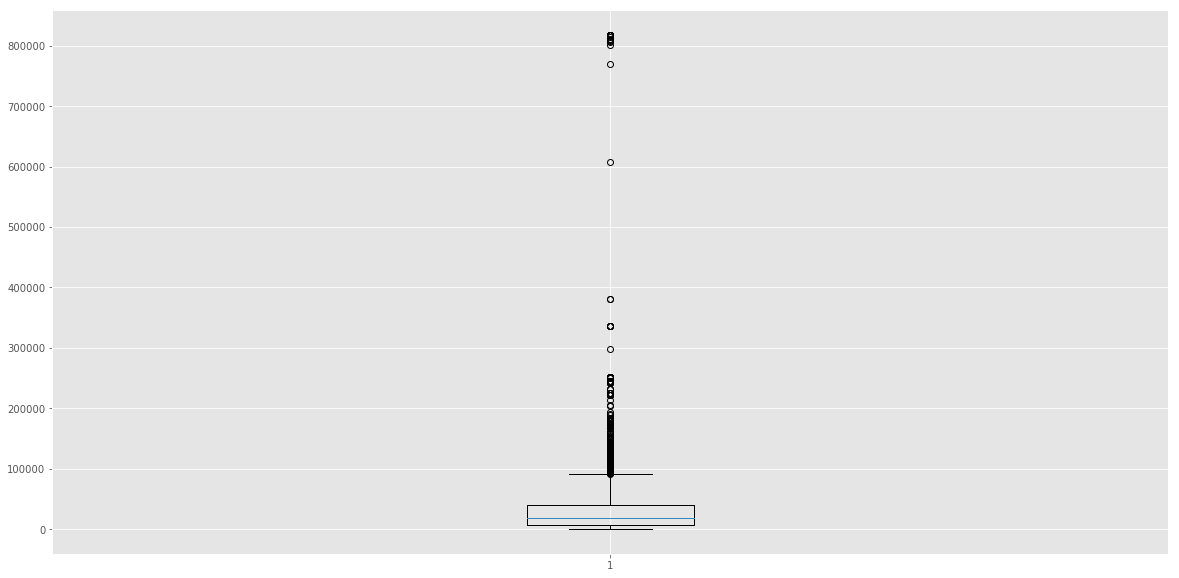

In [36]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = fig_size
plt.boxplot(naive_processing_times)

In [37]:
raw_data_frame_finalised

,id_product,batch_number,manufacturer_id,model_id,process_type_path,sold_to,warranty,finish_processing,value,product_type,process_id,start_time,end_time,station_id,product_id,process_type,pass_fail,box_id
start_time,,,,,,,,,,,,,,,,,,
2015-11-10 16:40:39,17,BR-015124,26,16,0,Adam - PL,0,1,None,mobile phone,112,2015-11-10 16:40:39,2015-11-10 16:51:45,5,17,1,1,300059
2015-11-10 16:51:54,17,BR-015124,26,16,0,Adam - PL,0,1,None,mobile phone,113,2015-11-10 16:51:54,2015-11-10 16:52:14,5,17,5,1,300059
2015-11-10 16:53:16,17,BR-015124,26,16,0,Adam - PL,0,1,None,mobile phone,114,2015-11-10 16:53:16,2015-11-10 16:53:22,5,17,2,1,300059
2015-11-10 16:53:39,17,BR-015124,26,16,0,Adam - PL,0,1,None,mobile phone,115,2015-11-10 16:53:39,2015-11-10 16:53:41,5,17,4,1,300059
2016-02-02 11:21:39,17,BR-015124,26,16,0,Adam - PL,0,1,None,mobile phone,21816,2016-02-02 11:21:39,2016-02-02 11:21:39,4,17,10,1,
2015-11-11 08:48:05,18,BR-015124,14,10,0,Simply Gadgets,28,1,None,mobile phone,116,2015-11-11 08:48:05,2015-11-11 08:51:30,5,18,1,1,300104
2015-11-11 08:51:52,18,BR-015124,14,10,0,Simply Gadgets,28,1,None,mobile phone,117,2015-11-11 08:51:52,2015-11-11 08:55:18,5,18,5,1,300104
2015-11-11 08:55:39,18,BR-015124,14,10,0,Simply Gadgets,28,1,None,mobile phone,118,2015-11-11 08:55:39,2015-11-11 08:59:19,5,18,2,1,300104
2015-11-11 08:59:23,18,BR-015124,14,10,0,Simply Gadgets,28,1,None,mobile phone,119,2015-11-11 08:59:23,2015-11-11 08:59:30,5,18,4,1,300104


In [38]:
processing_times_data

id_product
17       {'process_route': [1, 5, 2, 4, 10], 'diff': [1...
18       {'process_route': [1, 5, 2, 4, 10, 10, 10], 'd...
19       {'process_route': [1, 5, 2, 4, 10], 'diff': [9...
20       {'process_route': [1, 5, 2, 4, 10], 'diff': [0...
21       {'process_route': [1, 5, 2, 10], 'diff': [2.5,...
24       {'process_route': [1, 5, 2, 10, 10, 10, 10], '...
34       {'process_route': [1, 5, 2, 4, 10, 10, 10], 'd...
41       {'process_route': [1, 2, 5, 4, 10], 'diff': [0...
43       {'process_route': [1, 2, 5, 4, 10], 'diff': [1...
44       {'process_route': [1, 2, 5, 4, 10, 10, 10, 10]...
45       {'process_route': [1, 2, 5, 4, 10], 'diff': [1...
46       {'process_route': [1, 5, 2, 4, 10, 10], 'diff'...
47       {'process_route': [1, 2, 5, 4, 10], 'diff': [0...
48       {'process_route': [1, 2, 5, 4, 10], 'diff': [6...
49       {'process_route': [1, 2, 5, 4, 10, 10, 10], 'd...
50       {'process_route': [1, 2, 5, 4, 10, 10, 10], 'd...
51       {'process_route': [1, 2, 5, 4, 10], 

In [39]:
processing_times_data.iloc[1]

{'diff': 5          3.78
 6          3.78
 7          3.73
 8     203057.62
 9     613528.37
 10      1215.23
 11    817812.51
 Name: diff, dtype: float64, 'process_route': 5      1
 6      5
 7      2
 8      4
 9     10
 10    10
 11    10
 Name: process_type, dtype: int64}

In [40]:
raw_data_frame_finalised[raw_data_frame_finalised['product_id'] == 44]

,id_product,batch_number,manufacturer_id,model_id,process_type_path,sold_to,warranty,finish_processing,value,product_type,process_id,start_time,end_time,station_id,product_id,process_type,pass_fail,box_id
start_time,,,,,,,,,,,,,,,,,,
2015-11-11 10:51:55,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,150,2015-11-11 10:51:55,2015-11-11 10:52:02,2,44,1,1,300067
2015-11-11 10:52:08,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,151,2015-11-11 10:52:08,2015-11-11 10:52:13,2,44,2,1,300067
2015-11-11 10:52:30,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,152,2015-11-11 10:52:30,2015-11-11 10:52:41,2,44,5,1,300067
2015-11-16 08:13:29,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,993,2015-11-16 08:13:29,2015-11-16 08:13:29,2,44,4,1,300067
2016-01-05 11:17:38,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,12351,2016-01-05 11:17:38,2016-01-05 11:17:38,0,44,10,1,
2017-05-31 11:27:01,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,170099,2017-05-31 11:27:01,2017-05-31 11:27:01,0,44,10,1,
2017-05-31 12:06:08,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,170512,2017-05-31 12:06:08,2017-05-31 12:06:08,0,44,10,1,
2017-06-01 07:02:24,44,BR-015644,6,15,0,Hikkado,28,1,None,mobile phone,171210,2017-06-01 07:02:24,2017-06-01 07:02:24,0,44,10,1,
